Importación de librerías:

En primer lugar, importo tensoflow para acceder a la base de datos de MNIST y poder trabajar con ella. Además, importo numpy para trabajar con arrays y matplotlib para visualizar los datos.

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2024-06-10 15:26:09.960451: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 15:26:10.817234: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 15:26:12.799984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 15:26:14.790582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tambien importo una librería con las funciones de activación y sus derivadas, necesarias tanto para la Forward como para la Backward Propagation.

In [3]:
from activ_func import softmax, sigmoid, sigmoid_p

ModuleNotFoundError: No module named 'activ_func'

Importación y normalización de datos

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/np.max(x_train) 
x_test = x_test/np.max(x_test)
x_train_reshaped = x_train.reshape(60000,784)
x_test_reshaped = x_test.reshape(10000,784)

Visualización de un dato

0


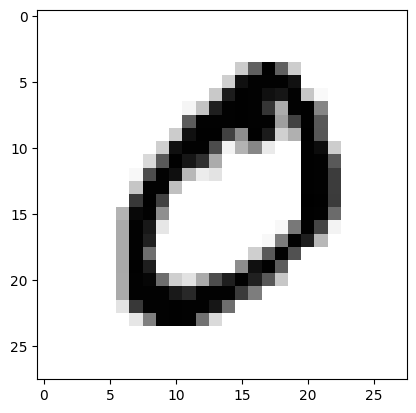

In [ ]:
plt.imshow(x_train[1], cmap=plt.cm.binary)
print(y_train[1])

Comienzo la implementación de las funciones necesarias para que funcione la red neuronal. Comenzando por el Forward Propagation, donde se calcula la salida de la red neuronal.

Defino las funciones que permiten el forward propagation de la informacion a traves de la red y calcula al final la matriz derivada de la pérdida:

$\delta^{(2)}=\frac{\partial L}{\partial z^{(2)}}$ 

En cada fila contiene el vector derivada de pérdida para cada elemento (imágen) del batch

In [ ]:
def final_loss(a_f,y):
    delta_2 = a_f - y
    return delta_2

def Forward_prop(a_0, g1, W1, b1, g2, W2, b2, y):
    z_1 = np.matmul(a_0, W1) + b1
    a_1 = g1(z_1)
    z_2 = np.matmul(a_1, W2) + b2
    a_2 = g2(z_2)
    delta_2 =final_loss(a_2,y)
    return z_1, a_1, a_2, delta_2

Defino la función encoder, que me transforma y = 2 en un vector que lo representa codificado en la notación de probabilidades como $y = [0,0,1,0,0,0,0,0,0,0]$. Cada entrada representa la probabilidad de que el número sea un número del 1 al 9

In [ ]:
def encoder(y):
    m = y.shape[0]
    enc = np.zeros((m,10))
    for j in range(m):
        enc[j,y[j]] = 1
    return enc

Con esto, ya tendríamos el forward propagation. A continuación se definirán las funciones que permiten back-propagate los errores y así corregir los pesos de las neuronas.

La función gradiente permite estimar las matrices que representan la derivada de la pérdida promedio del batch (que predice simultáneamente n imágenes distintas) usadas para el SGD:

 $$\overline{L}=\frac{1}{n}\sum_{i=1}^{n} L$$

Partimos de que $L$ está directamente relacionado con las funciones $\delta$ según 

$$\frac{\partial L}{\partial w_{j'j}^{(l)}} = \delta_{j'}^{(l)} a_j^{(l-1)}$$

$$\frac{\partial L}{\partial b_{j'}^{(l)}} = \delta_{j'}^{(l)}$$

El promedio de estas matrices se calculará simplemente haciendo 

$$\frac{\partial \overline{L}}{\partial w_{j'j}^{(l)}} = \frac{1}{n}\sum_{i=1}^{n}\delta_{j'}^{(l)} a_j^{(l-1)}$$

$$\frac{\partial \overline{L}}{\partial b_{j'}^{(l)}} = \frac{1}{n}\sum_{i=1}^{n}\delta_{j'}^{(l)}$$


Nota: la matriz $\frac{\partial L}{\partial w_{j'j}^{(l)}}$ se genera mediante la multiplicacion del vector $a^{(1)}$ columna por el vector $\delta^{(2)}$ fila; el orden es contrario al que aparece en la expresión teórica, pues para deducirla, las multiplicaciones se han realizado como matriz por vector columna, pero para implementarlas se ha multiplicado vector fila por matriz. Por lo tanto la matriz W está traspuesta respecto a lo que indica la teoría y necesito trasponer también sus actualizaciones (derivadas). Esto es equivalente a trasponer la matriz generada multiplicando $\delta^{(2)}$ columna por $a^{(1)}$ fila

In [ ]:
def gradient(delta_f, a_i):
    n = delta_f.shape[0]
    dL_dw_f = np.zeros((a_i.shape[1], delta_f.shape[1]))
    dL_db_f = np.zeros((1, delta_f.shape[1]))
    for i in range(n):
        dL_dw_f += np.matmul(np.array([a_i[i]]).transpose(), [delta_f[i]])/n #me calcula el promedio
        dL_db_f += delta_f[i,:]/n
    return dL_dw_f, dL_db_f

También he implementado la función delta_i, que propaga hacia atrás el valor de $\delta$ según la siguiente expresión:

$\delta^{(l-1)}=\frac{dg(z_i)}{dz}\cdot(W^{(l)})^T\cdot\delta^{(l)}$

Nota: la multiplicación por la derivada de la función de activación es componente a componente y no producto escalar.

In [ ]:
def delta_i(delta_f, dg_dz_i, z_i, W_f):
    return dg_dz_i(z_i) * np.matmul(delta_f, W_f.transpose())

Una vez conocido el gradiente puedo crear la funcion Backward_prop, que corrige los pesos de las neuronas

In [ ]:
def Backward_prop(delta_2, W2, b2, delta_1, W1, b1, a_1, a_0, alpha1, alpha2):  # alpha son los learning rate
    dL_dw_2, dL_db_2 = gradient(delta_2, a_1)
    W2 = W2 - alpha2 * dL_dw_2
    b2 = b2 - alpha2 * dL_db_2

    dL_dw_1, dL_db_1 = gradient(delta_1, a_0)
    W1 = W1 - alpha1 * dL_dw_1
    b1 = b1 - alpha1 * dL_db_1
    
    return W1, b1, W2, b2

El algoritmo de optimización Stochastic Gradient Descend consiste en propagar hacia delante nuevamente usando un batch diferente para seguir corrigiendo el modelo. Pero antes, veamos el proceso de una iteración con un batch determinado

In [ ]:
W1_ini = np.random.randn(784, 10)
b1_ini = np.zeros((10,))
W2_ini = np.random.randn(10,10)
b2_ini = np.zeros((10,))
batch_size = 6
x_batch = x_train_reshaped[np.arange(0,batch_size)]
y_batch = y_train[np.arange(0,batch_size)]
a_0 = x_batch
y_batch = encoder(y_batch)#lo codifico en el formato probabilistico
z_1,a_1,a_2,delta_2 = Forward_prop(a_0,sigmoid,W1_ini,b1_ini,softmax,W2_ini,b2_ini,y_batch)
delta_1 = delta_i(delta_2,sigmoid_p,z_1,W2_ini)
W1,b1,W2,b2 = Backward_prop(delta_2,W2_ini,b2_ini,delta_1,W1_ini,b1_ini,a_1,a_0,10,10)


Ahora que ya sabemos cómo funciona una iteración vamos a crear una funcion optimizador que automatice este proceso barriendo todos los datos de entrenamiento en batches. Pero antes es necesario particionar los datos en batches. La función batch_gen se encargará de ello.

In [ ]:
def batch_gen (n_batches,x_train_reshaped,y_train):
    n_muestras = x_train_reshaped.shape[0]
    length_muestrasx = x_train_reshaped.shape[1]
    y_train_enc = encoder(y_train)
    length_muestrasy = y_train_enc.shape[1]
    batch_size = n_muestras/n_batches
    batch_size = int(batch_size)

    x_batches = np.empty((n_batches,batch_size,length_muestrasx))
    y_batches = np.empty((n_batches, batch_size, length_muestrasy))
    for i in range(0,n_batches):
        x_batches[i,:] = x_train_reshaped[np.arange(i*batch_size,i*batch_size+batch_size).astype(int)]
        y_batches[i,:] = y_train_enc[np.arange(i*batch_size,i*batch_size+batch_size).astype(int)]

    return x_batches, y_batches

Prueba de funcionamiento del generador de batches.

In [ ]:
n_batches = 10000
x_batches,y_batches = batch_gen(n_batches,x_train_reshaped,y_train)
print('Dimension x_batches: ',x_batches.shape,". Dimension y_batches:", y_batches.shape)

Dimension x_batches:  (10000, 6, 784) . Dimension y_batches: (10000, 6, 10)


También quiero calcular las perdidas L en la ultima capa para pasarlas por la línea de comandos y revisar si el modelo está aprendiendo correctamente.

In [ ]:
def loss(a_2,y_batch):
    return np.mean(np.sum(-y_batch*np.log(a_2),axis=1))

Importo una librería para mostrar el proceso de entrenamiento en el epoch

In [ ]:
from tqdm import tqdm

Creo la función de entrenamiento que se encargará de entrenar la red neuronal recorriendo todos los datos de entrenamiento en batches y actualizando los pesos de las neuronas. 

Optimizer particiona los datos en batches, calcula las salidas de cada capa, los errores de cada capa y actualiza los pesos de las neuronas, es decir hace el forward y el backward propagation para todos los datos segmentados en batches.

In [ ]:
def optimizer(W1_ini,b1_ini,W2_ini,b2_ini,x_train_reshaped,y_train,n_batches,alpha1,alpha2):
    x_batches,y_batches = batch_gen(n_batches,x_train_reshaped,y_train)
    W1, b1 = W1_ini, b1_ini
    W2, b2 = W2_ini, b2_ini
    for n_batch in tqdm(range(n_batches), desc="Training Progress", unit="batch"):
        y_batch = y_batches[n_batch]
        a_0 = x_batches[n_batch]
        z_1,a_1,a_2,delta_2 = Forward_prop(a_0,sigmoid,W1,b1,softmax,W2,b2,y_batch)
        delta_1 = delta_i(delta_2,sigmoid_p,z_1,W2)
        W1,b1,W2,b2 = Backward_prop(delta_2,W2,b2,delta_1,W1,b1,a_1,a_0,alpha1,alpha2)
    L = loss(a_2,y_batch)
    return W1,b1,W2,b2,L

Vamos a llamar a la funcion a que haga la optimizacion epoch-veces.

Los hiperparámetros son: 
- learning rate = 1
- epochs = 15
- n_batches = 1000

Se pueden modificar para mejorar el rendimiento del modelo.

In [ ]:
W1_ini = np.random.randn(784, 10)
b1_ini = np.zeros((10,))
W2_ini = np.random.randn(10,10)
b2_ini = np.zeros((10,))
epoch = 10
for i in range(epoch):
    W1,b1,W2,b2,L = optimizer(W1_ini,b1_ini,W2_ini,b2_ini,x_train_reshaped,y_train,n_batches=1000,alpha1=0.5,alpha2=0.5)
    W1_ini,b1_ini,W2_ini,b2_ini = W1,b1,W2,b2
    print('epoch',i+1,', Loss = ',L)

Training Progress: 100%|██████████| 1000/1000 [00:03<00:00, 276.87batch/s]


epoch 1 , Loss =  0.6670155613569785


Training Progress: 100%|██████████| 1000/1000 [00:03<00:00, 267.67batch/s]


epoch 2 , Loss =  0.43307003979319636


Training Progress: 100%|██████████| 1000/1000 [00:03<00:00, 280.03batch/s]


epoch 3 , Loss =  0.27363857421299664


Training Progress: 100%|██████████| 1000/1000 [00:03<00:00, 284.74batch/s]


epoch 4 , Loss =  0.23372585425706568


Training Progress: 100%|██████████| 1000/1000 [00:03<00:00, 298.50batch/s]

epoch 5 , Loss =  0.20308651095831234


Nota: debe observarse que la función de pérdida Loss disminuye con el tiempo, lo que indica que el modelo está aprendiendo. Un buen valor de pérdida en este caso es 0.15.


Guardo las matrices de pesos y bias en un archivo para no tener que volver a entrenar el modelo

In [ ]:
np.save('W1.npy', W1)
np.save('b1.npy', b1)
np.save('W2.npy', W2)
np.save('b2.npy', b2)

Cargo los pesos y bias guardados

In [ ]:
W1=np.load('W1.npy')
b1=np.load('b1.npy')
W2=np.load('W2.npy')
b2=np.load('b2.npy')

Defino una función que me permita predecir un número a partir de una imágen (básicamente forward propagation con los pesos optimizados).

In [ ]:
def predict(W1,b1,W2,b2,x_test_reshaped):
    a_0 = x_test_reshaped
    z_1 = np.matmul(a_0,W1) + b1
    a_1 = sigmoid(z_1)
    z_2 = np.matmul(a_1,W2) + b2
    a_2 = softmax(z_2)
    return a_2

Creo un decodificador para las predicciones, para faciliar la comprobación de los resultados con y_test.

Decode convierte el vector de probabilidades en un número entero del 0 al 9.

In [ ]:
def decode(y):
    return np.argmax(y,axis=1)

Una vez el modelo ha sido entrenado, se realizan las predicciones y se estima la tasa de acierto.

$$tasa = 1 -\frac{errores}{predicciones}$$

In [ ]:
y_pred = predict(W1,b1,W2,b2,x_test_reshaped)
n_err = 0
m = y_pred.shape[0]
for i in range(m):
    if decode(y_pred)[i] != y_test[i]:
        n_err += 1
tasa_acierto = 1 - n_err/m
print('Tasa de acierto =',tasa_acierto)

Tasa de acierto = 0.888
